<a href="https://colab.research.google.com/github/Rijan4449/BXGBoost/blob/main/BSXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import time
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, confusion_matrix, ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import category_encoders as ce
from xgboost import XGBClassifier

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/super_dataset.csv")
ph_path = "/content/drive/My Drive/Colab Notebooks/ph_waters.txt"

with open(ph_path, "r", encoding="utf-8") as f:
    ph_waters = {line.strip() for line in f if line.strip()}


In [5]:
# -----------------------
# 1. Load dataset
# -----------------------

# Load dataset
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/super_dataset.csv")

# PH waters (for test split)
with open("/content/drive/My Drive/Colab Notebooks/ph_waters.txt", "r", encoding="utf-8") as f:
    ph_waters = {line.strip() for line in f if line.strip()}

ph_test = df[df["waterbody_name"].isin(ph_waters)]
non_ph = df[~df["waterbody_name"].isin(ph_waters)]
test_size = int(0.2 * len(df))

if len(ph_test) < test_size:
    additional_needed = test_size - len(ph_test)
    extra_non_ph = non_ph.sample(n=additional_needed, random_state=42)
    test_set = pd.concat([ph_test, extra_non_ph])
    train_set = df.drop(test_set.index)
else:
    test_set = ph_test
    train_set = non_ph


In [6]:
# -----------------------
# 2. Define bins and labels for risk classes
# -----------------------
bins = [0, 0.33, 0.66, 1.0]
labels = ['Low', 'Medium', 'High']

train_set['risk_class'] = pd.cut(train_set['invasion_risk_score'], bins=bins, labels=labels, include_lowest=True)
test_set['risk_class']  = pd.cut(test_set['invasion_risk_score'], bins=bins, labels=labels, include_lowest=True)

# Encode labels
le = LabelEncoder()
train_set['risk_class_enc'] = le.fit_transform(train_set['risk_class'])
test_set['risk_class_enc']  = le.transform(test_set['risk_class'])

In [7]:
# -----------------------
# 3. Preprocessor setup
# -----------------------
drop_cols = ['fish_id', 'common_name', 'status']
high_cardinality = ['species', 'waterbody_name']
low_cardinality = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'feeding_type']
numeric_cols = [
    'temp_max', 'weight_max', 'length_max',
    'temp_pref_min', 'temp_pref_max',
    'temp_range_min', 'temp_range_max',
    'trophic_lvl_estimate_min', 'trophic_lvl_estimate_max', 'trophic_lvl',
    'fecundity_mean', 'fecundity_min', 'fecundity_max',
    'wb_ph_min', 'wb_ph_max',
    'wb_salinity_min', 'wb_salinity_max',
    'wb_do_min', 'wb_do_max',
    'wb_bod_min', 'wb_bod_max',
    'wb_turbidity_min', 'wb_turbidity_max',
    'wb_temp_min', 'wb_temp_max'
]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

low_card_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

high_card_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target', ce.TargetEncoder())
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('low_cat', low_card_transformer, low_cardinality),
    ('high_cat', high_card_transformer, high_cardinality)
], remainder='drop')

In [8]:
start_time = time.time()

In [9]:
# -----------------------
# 4. Pipeline with SMOTE + XGB
# -----------------------
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),  # for sparse
    ('smote', SMOTE(random_state=42, k_neighbors=5)),
    ('model', XGBClassifier(
        eval_metric='mlogloss',  # no use_label_encoder
        n_estimators=100,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_lambda=1,
        random_state=42
    ))
])

In [10]:
# ===========================
# 5. KFold CV
# ===========================
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {m: [] for m in ["accuracy", "precision", "recall", "f1", "roc_auc", "logloss", "train_accuracy"]}
all_y_true, all_y_pred, all_y_probs = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_set), 1):
    X_tr = train_set.iloc[train_idx].drop(columns=drop_cols + ['risk_class', 'risk_class_enc'])
    X_val = train_set.iloc[val_idx].drop(columns=drop_cols + ['risk_class', 'risk_class_enc'])
    y_tr, y_val = train_set['risk_class_enc'].iloc[train_idx], train_set['risk_class_enc'].iloc[val_idx]

    print(f"\nFOLD {fold} | Before SMOTE: {Counter(y_tr)}")

    # Optional: check SMOTE manually
    X_tr_processed = preprocessor.fit_transform(X_tr, y_tr)
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_tr_processed, y_tr)
    print("After SMOTE: ", Counter(y_res))

    # Fit pipeline
    pipeline.fit(X_tr, y_tr)
    y_pred_val = pipeline.predict(X_val)
    y_pred_tr = pipeline.predict(X_tr)
    y_val_probs = pipeline.predict_proba(X_val)

    # Store OOF predictions
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred_val)
    all_y_probs.extend(y_val_probs)

    # Metrics
    cv_results["accuracy"].append(accuracy_score(y_val, y_pred_val))
    cv_results["precision"].append(precision_score(y_val, y_pred_val, average="weighted", zero_division=0))
    cv_results["recall"].append(recall_score(y_val, y_pred_val, average="weighted"))
    cv_results["f1"].append(f1_score(y_val, y_pred_val, average="weighted"))
    cv_results["roc_auc"].append(roc_auc_score(pd.get_dummies(y_val), y_val_probs, multi_class="ovr"))
    cv_results["logloss"].append(log_loss(y_val, y_val_probs))
    cv_results["train_accuracy"].append(accuracy_score(y_tr, y_pred_tr))

end_time = time.time()


FOLD 1 | Before SMOTE: Counter({0: 1785, 1: 1481, 2: 307})
After SMOTE:  Counter({0: 1785, 1: 1785, 2: 1785})

FOLD 2 | Before SMOTE: Counter({0: 1796, 1: 1467, 2: 310})
After SMOTE:  Counter({0: 1796, 1: 1796, 2: 1796})

FOLD 3 | Before SMOTE: Counter({0: 1799, 1: 1478, 2: 297})
After SMOTE:  Counter({0: 1799, 1: 1799, 2: 1799})

FOLD 4 | Before SMOTE: Counter({0: 1797, 1: 1466, 2: 311})
After SMOTE:  Counter({0: 1797, 2: 1797, 1: 1797})

FOLD 5 | Before SMOTE: Counter({0: 1791, 1: 1468, 2: 315})
After SMOTE:  Counter({0: 1791, 1: 1791, 2: 1791})


In [11]:
# ===========================
# 6. Results
# ===========================
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc", "logloss"]
for metric in metrics:
    print(f"\n{metric.upper()}:")
    for i, score in enumerate(cv_results[metric], 1):
        print(f"Fold-{i}: {score:.4f}")
    print(f"Mean {metric.upper()}: {np.nanmean(cv_results[metric]):.4f}")

gen_gap = np.array(cv_results["train_accuracy"]) - np.array(cv_results["accuracy"])
print("\nGENERALIZATION GAP per fold:")
for i, gap in enumerate(gen_gap, 1):
    print(f"Fold-{i}: {gap:.4f}")
print(f"Mean Generalization Gap: {np.mean(gen_gap):.4f}")

from sklearn.metrics import roc_auc_score
overall_roc_auc = roc_auc_score(pd.get_dummies(all_y_true), np.array(all_y_probs), multi_class="ovr")
overall_logloss = log_loss(pd.get_dummies(all_y_true), np.array(all_y_probs))
print(f"\nOVERALL ROC-AUC: {overall_roc_auc:.4f}")
print(f"OVERALL LOGLOSS: {overall_logloss:.4f}")


ACCURACY:
Fold-1: 0.8076
Fold-2: 0.8087
Fold-3: 0.7928
Fold-4: 0.8320
Fold-5: 0.8231
Mean ACCURACY: 0.8129

PRECISION:
Fold-1: 0.8226
Fold-2: 0.8216
Fold-3: 0.8328
Fold-4: 0.8370
Fold-5: 0.8270
Mean PRECISION: 0.8282

RECALL:
Fold-1: 0.8076
Fold-2: 0.8087
Fold-3: 0.7928
Fold-4: 0.8320
Fold-5: 0.8231
Mean RECALL: 0.8129

F1:
Fold-1: 0.7915
Fold-2: 0.7941
Fold-3: 0.7719
Fold-4: 0.8114
Fold-5: 0.8120
Mean F1: 0.7962

ROC_AUC:
Fold-1: 0.9362
Fold-2: 0.9441
Fold-3: 0.9352
Fold-4: 0.9423
Fold-5: 0.9355
Mean ROC_AUC: 0.9387

LOGLOSS:
Fold-1: 0.6039
Fold-2: 0.6471
Fold-3: 0.6671
Fold-4: 0.5659
Fold-5: 0.5639
Mean LOGLOSS: 0.6096

GENERALIZATION GAP per fold:
Fold-1: 0.1916
Fold-2: 0.1904
Fold-3: 0.2066
Fold-4: 0.1671
Fold-5: 0.1761
Mean Generalization Gap: 0.1864

OVERALL ROC-AUC: 0.9368
OVERALL LOGLOSS: 0.6096


In [12]:
# -----------------------
# Experiment 2: Tuning statistics
# -----------------------
total_time = end_time - start_time
num_iterations = kf.get_n_splits()
time_per_iteration = total_time / num_iterations

# Convert CV results to array (handles dict or list)
val_scores = np.array(cv_results["accuracy"])  # or replace with "f1", etc.
variance = np.var(val_scores, ddof=1)  # sample variance (unbiased)

print("\nEXPERIMENT 2 - TUNING STATISTICS")
print(f"Total tuning time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
print(f"Number of iterations/folds: {num_iterations}")
print(f"Time per iteration: {time_per_iteration:.2f} seconds")
print(f"Validation score mean: {np.mean(val_scores):.4f}")
print(f"Validation score variance: {variance:.6f}")



EXPERIMENT 2 - TUNING STATISTICS
Total tuning time: 84.45 seconds (1.41 minutes)
Number of iterations/folds: 5
Time per iteration: 16.89 seconds
Validation score mean: 0.8129
Validation score variance: 0.000229


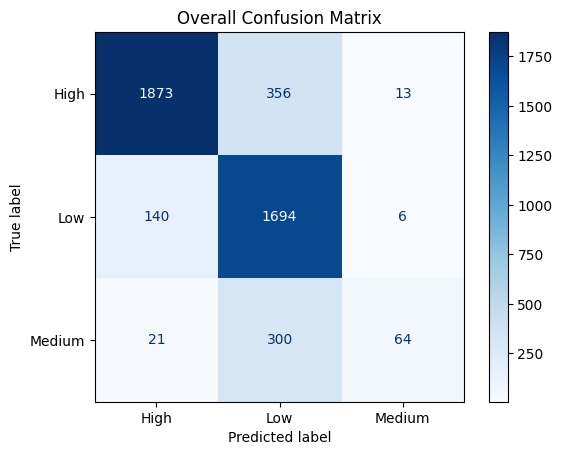

In [13]:
# Compute confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)  # optional: choose color map
plt.title("Overall Confusion Matrix")
plt.show()


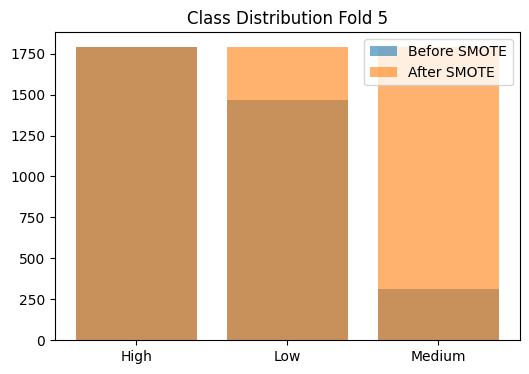

In [14]:
from collections import Counter

# Count before SMOTE
before_counts = Counter(y_tr)

# Fit pipeline (SMOTE happens inside)
pipeline.fit(X_tr, y_tr)

# Extract balanced counts from SMOTE step
X_res, y_res = pipeline.named_steps['smote'].fit_resample(
    pipeline.named_steps['preprocessor'].transform(X_tr), y_tr
)
after_counts = Counter(y_res)

# Plot class distribution before vs after
plt.figure(figsize=(6,4))
plt.bar(before_counts.keys(), before_counts.values(), alpha=0.6, label="Before SMOTE")
plt.bar(after_counts.keys(), after_counts.values(), alpha=0.6, label="After SMOTE")
plt.xticks([0,1,2], le.classes_)
plt.title(f"Class Distribution Fold {fold}")
plt.legend()
plt.show()


In [ ]:
import joblib

# Save the trained model
joblib.dump(xgb_model, "/content/drive/My Drive/Colab Notebooks/xgb_manual_invasion_model_9_18.pkl")

# Later, load it back
xgb_loaded = joblib.load("/content/drive/My Drive/Colab Notebooks/xgb_manual_invasion_model_9_18.pkl")